In [1]:
import pandas as pd
import os 
import random
import subprocess

import dask.dataframe as dd
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [19]:
biovar = 'bio18'

In [3]:
kendall_corr = pd.read_csv(f'../kendall_tau/kendall_corr_{biovar}.csv')

In [4]:
kendall_corr

,id,pos,chrom,K_tau,K_tau_p,MAF,block
0,1_346,346,1,-0.009168,8.078257e-01,0.281796,1_0
1,1_353,353,1,-0.088595,1.875348e-02,0.074906,1_0
2,1_363,363,1,-0.009974,7.913147e-01,0.104640,1_0
3,1_395,395,1,-0.261328,4.216954e-12,0.065442,1_0
4,1_396,396,1,-0.261328,4.216954e-12,0.065442,1_0
...,...,...,...,...,...,...,...
1054569,5_26975078,26975078,5,0.223621,2.988543e-09,0.161471,5_3110
1054570,5_26975121,26975121,5,-0.072967,5.290657e-02,0.072238,5_3110
1054571,5_26975148,26975148,5,-0.072967,5.290657e-02,0.072238,5_3110
1054572,5_26975272,26975272,5,-0.022709,5.468530e-01,0.474359,5_3110


In [5]:
path = '/carnegie/nobackup/scratch/tbellagio/gea_grene-net/wza'

In [6]:
## create a dir 
#wza_results_lfmm_bio1_poly7

# create sbatch files to submit on cedar server
shfiles = []

seed = random.randint(1,100000000)
file = 'wza.sh'
cmd = f'python general_WZA_script_mod_polynomial_order7.py \
        --correlations ../kendall_tau/kendall_corr_{biovar}.csv \
        --summary_stat K_tau_p --window "block" \
        --output wza_kendalltau_results_{biovar}_poly7.csv --sep ","'
text = f'''#!/bin/bash
#SBATCH --job-name=wza
#SBATCH --time=1:00:00  # Time limit set to 4 days
#SBATCH --ntasks=1
#SBATCH --mem-per-cpu=30gb
#SBATCH --output=wza_%j.out
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

module load python/3.11_conda
conda activate /home/tbellagio/miniforge3/envs/pipeline_snakemake
export LD_LIBRARY_PATH="/home/tbellagio/miniforge3/envs/run_baypass/lib:$LD_LIBRARY_PATH"
cd /carnegie/nobackup/scratch/tbellagio/gea_grene-net/wza
{cmd}


'''
with open(file, 'w') as o:
    o.write("%s" % text)
shfiles.append(file)

In [7]:
## now run the shfiles
for shfile in shfiles:
    # Submit each sbatch script to the SLURM scheduler
    subprocess.run(["sbatch", shfile], check=True)

Submitted batch job 58108


In [12]:
wza = pd.read_csv(f'wza_kendalltau_results_{biovar}_poly7.csv').reset_index()

/tmp/ipykernel_1655532/788878766.py:1: RuntimeWarning: divide by zero encountered in log10
  observed_quantiles = -np.log10(np.sort(wza['Z_pVal'].values))


NameError: name 'biovar' is not defined

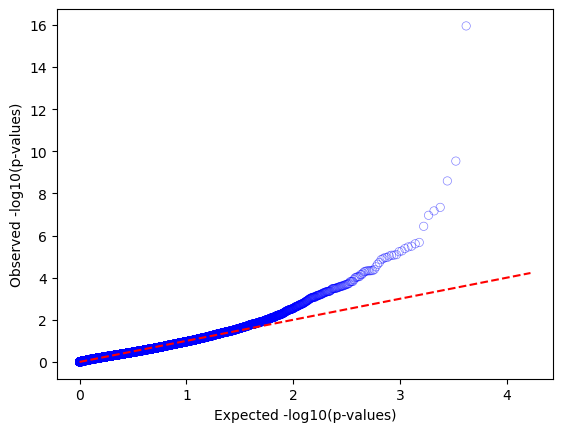

In [5]:
observed_quantiles = -np.log10(np.sort(wza['Z_pVal'].values))

# Expected quantiles from the uniform distribution
expected_quantiles = -np.log10(np.linspace(1 / len(wza), 1, len(wza)))

# QQ plot
sns.scatterplot(x = expected_quantiles, y = observed_quantiles, edgecolor='b', facecolor='none', alpha=0.5)
plt.plot([min(expected_quantiles), max(expected_quantiles)], [min(expected_quantiles), max(expected_quantiles)], 'r--')

plt.xlabel("Expected -log10(p-values)")
plt.ylabel("Observed -log10(p-values)")
plt.title(f'QQ Plot for {biovar}) WZA')

plt.show()

In [16]:
wza['chrom'] = wza['gene'].str.split('_').str[0].astype(int)
wza['pos'] = wza['gene'].str.split('_').str[1].astype(int)

/tmp/ipykernel_1201391/1426776967.py:39: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


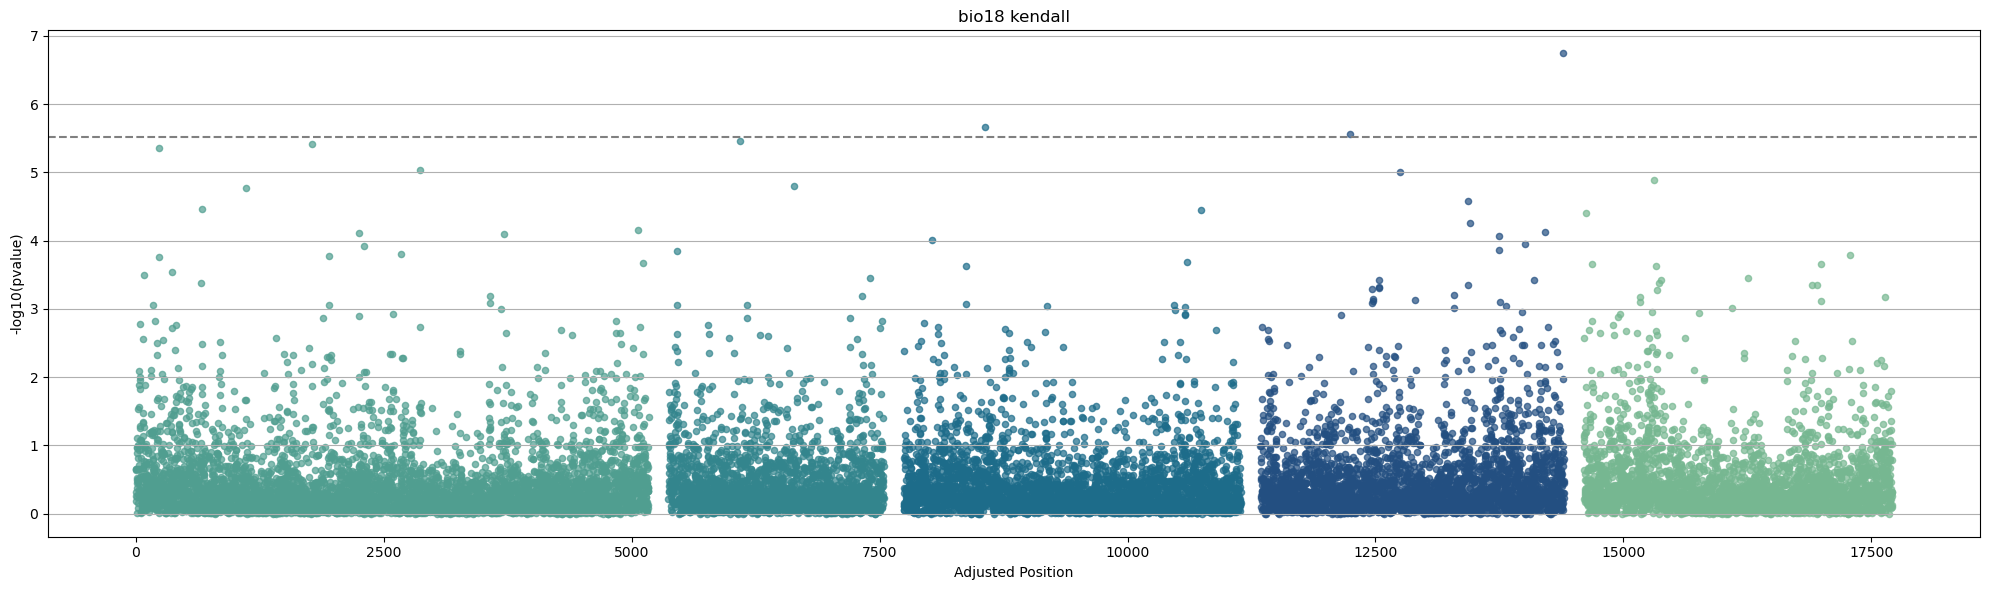

In [20]:
threshold_value = 0.05 / len(wza)

#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = wza[['Z_pVal','pos','chrom']].copy()


# Parsing chromosome number and position
df['chromosome'] = df['chrom']
df['position'] = df['pos']
df['-log10(pvalue)'] = -np.log10(df['Z_pVal'])

colors = sns.color_palette("crest", n_colors = 5)

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 200  # Buffer to prevent overlap

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Normalize sizes for better visualization
size_transform = 2  # Adjust this factor as needed


# Create a color map based on `n_est`
#df['color'] = df['n_est'].map(lambda x: cmap(norm(x)))

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(
        subset['adjusted_position'],
        subset['-log10(pvalue)'],
        alpha=0.7,  # Transparency for better visibility
        c=colors[chrom % len(colors)], 
        label=f'Chr {chrom}',
            s= 20)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
plt.title(f'{biovar} kendall')  # Set the title
plt.grid(axis='y')



# Create a legend for the number of estimated lineages
#handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(norm(n)), markersize=10, label=f'Lineages {n}') for n in sorted(n_est_unique)]
#plt.legend(handles=handles, title="Estimated Lineages", bbox_to_anchor=(1.05, 1), loc='upper left')

# Threshold line
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')

# Show the plot
plt.tight_layout()
plt.savefig(f'manhattan_kendall_{biovar}')
plt.show()


In [ ]:
#genes = ['2_199', '3_2730', '5_2244']
genes = ['2_1265', '4_801']
# Add circles around the specific genes
for gene in genes:
    chrom, pos = map(int, gene.split('_'))
    subset_gene = df[(df['chromosome'] == chrom) & (df['position'] == pos)]
    if not subset_gene.empty:
        plt.scatter(
            subset_gene['adjusted_position'],
            subset_gene['-log10(pvalue)'],
            edgecolor='red',  # Color of the edge of the circle
            linewidth=2,      # Width of the edge line
            facecolor='none', # Facecolor of the circle (None means transparent)
            s=100,            # Size of the circle
            label=f'Gene {gene}'
        )

/tmp/ipykernel_3175312/1489910986.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


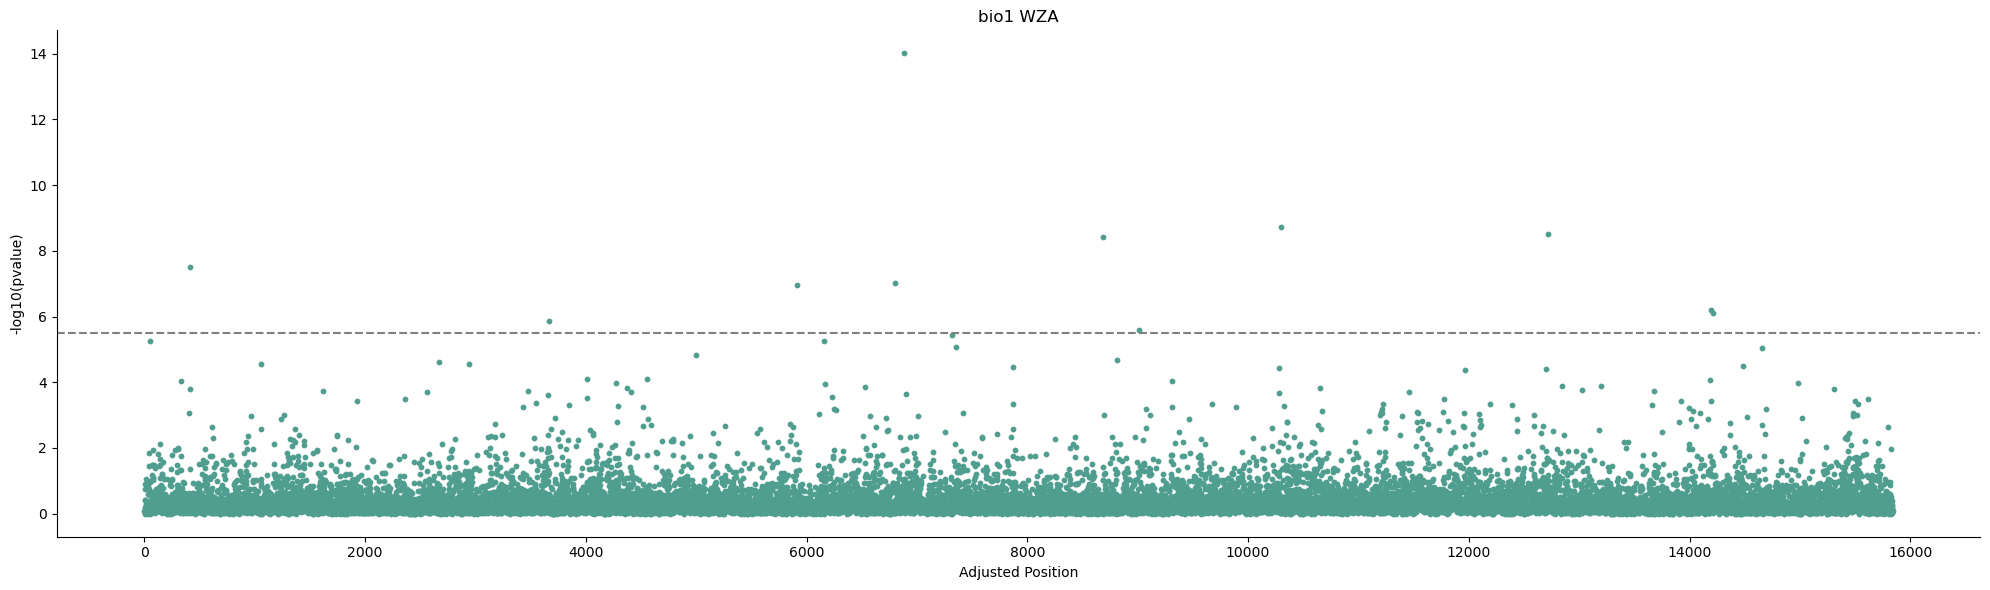

In [54]:
threshold_value = 0.05 / len(wza)
biovar='bio1'
#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = wza[['Z_pVal', 'index']].copy()

colors = sns.color_palette("crest", n_colors = 5)

# Parsing chromosome number and position
df['chromosome'] = 1
df['position'] = df['index']
df['-log10(pvalue)'] = -np.log10(df['Z_pVal'])

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 1000000  # Adding 1 million as a buffer between chromosomes

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
#plt.title('Manhattan Plot')
#plt.grid(axis='y')
#plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove the top spine
ax.spines['right'].set_visible(False)
# Threshold line (optional)
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')
plt.title(f'{biovar} WZA')  # Set the title

# Show the plot
plt.tight_layout()
#plt.savefig(f'manhattan_{biovar}.png')
plt.show()

/tmp/ipykernel_3175312/2368688080.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)


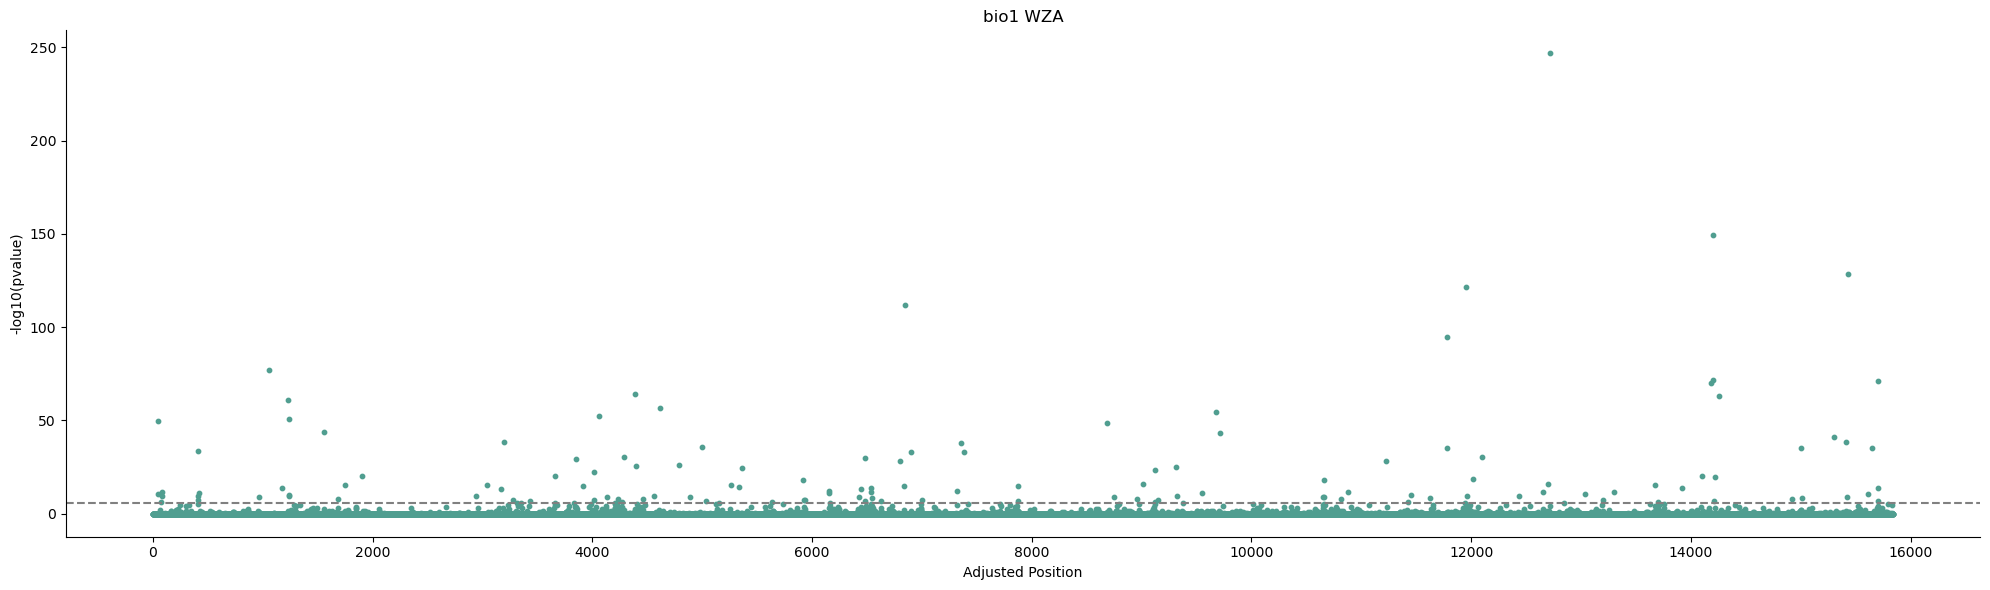

In [50]:
threshold_value = 0.05 / len(wza)
biovar='bio1'
#sm.qqplot(pvalues['pvalue'], line ='45') 
#py.show() 

df = wza[['top_candidate_p', 'index']].copy()

colors = sns.color_palette("crest", n_colors = 5)

# Parsing chromosome number and position
df['chromosome'] = 1
df['position'] = df['index']
df['-log10(pvalue)'] = -np.log10(df['top_candidate_p'])

# Calculate the offset for each chromosome to prevent overlap
chromosome_offsets = {}
offset = 0
for chrom in sorted(df['chromosome'].unique()):
    chromosome_offsets[chrom] = offset
    max_position = df[df['chromosome'] == chrom]['position'].max()
    offset += max_position + 1000000  # Adding 1 million as a buffer between chromosomes

# Apply offsets to positions
df['adjusted_position'] = df.apply(lambda row: row['position'] + chromosome_offsets[row['chromosome']], axis=1)

# Creating the Manhattan plot
plt.figure(figsize=(20, 6))

for chrom in sorted(df['chromosome'].unique()):
    subset = df[df['chromosome'] == chrom]
    plt.scatter(subset['adjusted_position'], subset['-log10(pvalue)'], c=colors[chrom % len(colors)], label=f'Chr {chrom}', s=10)

# Aesthetics
plt.xlabel('Adjusted Position')
plt.ylabel('-log10(pvalue)')
#plt.title('Manhattan Plot')
#plt.grid(axis='y')
#plt.legend(title="Chromosome", bbox_to_anchor=(1.05, 1), loc='upper left')
ax = plt.gca()  # Get current axes
ax.spines['top'].set_visible(False)  # Remove the top spine
ax.spines['right'].set_visible(False)
# Threshold line (optional)
threshold = -np.log10(threshold_value)
plt.axhline(y=threshold, color='grey', linestyle='dashed')
plt.title(f'{biovar} WZA')  # Set the title

# Show the plot
plt.tight_layout()
plt.savefig(f'manhattan_{biovar}.png')
plt.show()